## Load and check

In [1]:
import pickle

In [2]:
with open('/project_final/orbitals.pkl', 'rb') as f:
    orbitals = pickle.load(f)

with open('/project_final/maneuvers.pkl', 'rb') as f:
    maneuvers = pickle.load(f)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [4]:
man = maneuvers['s3a']

In [5]:
df = orbitals['Sentinel-3A.csv'].copy()

In [6]:
df.index = pd.to_datetime(df.index)

# keep only year-month-day
df.index = df.index.normalize()

## Modelling

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
import os

In [8]:
def set_seed(seed=42):
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [9]:
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data) - window_size + 1)])

In [10]:
def create_lstm_autoencoder(window_size, n_features, learning_rate=0.01):
    inputs = Input(shape=(window_size, n_features))
    encoded = LSTM(32, return_sequences=False)(inputs)
    # encoded = Dropout(0.1)(encoded)
    encoded = Dense(8, activation='tanh')(encoded)

    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(32, return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)

    model = Model(inputs, decoded)
    model.compile(optimizer=Adam(learning_rate), loss='mae')
    return model

In [11]:
def train_autoencoder_and_get_residual(df, window_size=3, split_ratio=1.0, epochs=20):
    data = df['Brouwer mean motion'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X_all = create_windows(scaled_data, window_size=window_size)

    set_seed(42)
    model = create_lstm_autoencoder(window_size=window_size, n_features=1)
    model.fit(X_all, X_all, epochs=epochs, batch_size=32, shuffle=False, verbose=0)

    all_pred = model.predict(X_all)

    residual_all = np.mean(np.abs(all_pred - X_all), axis=(1, 2))
    # residual_test = np.mean(np.abs(test_pred - X_test), axis=(1, 2))
    # residual_all = np.concatenate([residual_train, residual_test])
    residual_index = df.index[window_size - 1:]

    return residual_all, residual_index

In [12]:
def plot_residual_diagnostics(residual_all, residual_index):
    residual_df = pd.DataFrame({'residual': residual_all}, index=residual_index)

    fig, ax = plt.subplots(1, 2, figsize=(18, 4.5))

    # 1. Time series plot
    residual_df['residual'].plot(ax=ax[0], title="Residual over Time")
    ax[0].set_ylabel("Residual")

    # 2. KDE plot
    residual_df['residual'].plot(kind='kde', ax=ax[1], title="Residual Density")
    ax[1].set_xlabel("Residual Value")

    # # 3. Normal QQ plot
    # stats.probplot(residual_df['residual'], dist="norm", plot=ax[2])
    # ax[2].set_title("Normal Q-Q Plot")

    plt.tight_layout()
    plt.show()

## Implementation

In [13]:
# residual_all, residual_index = train_autoencoder_and_get_residual(df, window_size=5, epochs=30)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


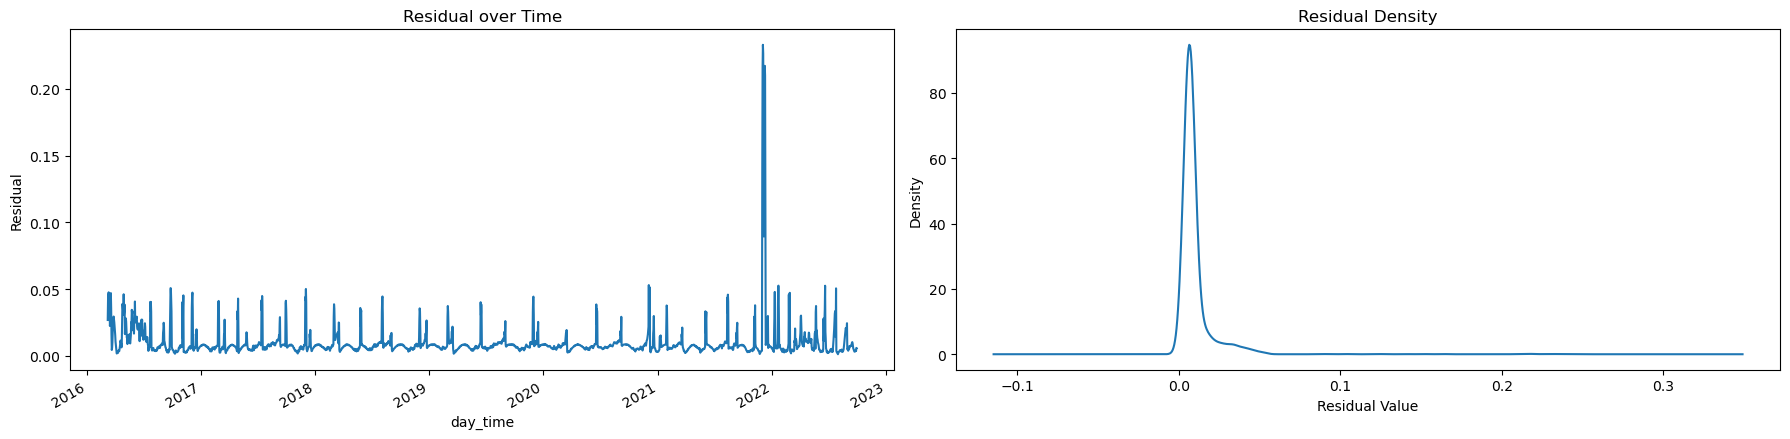

In [14]:
residual_all, residual_index = train_autoencoder_and_get_residual(
    df, window_size=5, epochs=30
)
plot_residual_diagnostics(residual_all, residual_index)

residual_df = pd.DataFrame({'timestamp': residual_index, 'residual': residual_all})

In [15]:
# data = df['Brouwer mean motion'].values.reshape(-1, 1)

In [16]:
# residual_actual = residual_all * (data.max() - data.min())

In [17]:
# residual_actual

## save residuals

In [18]:
residual_df = pd.DataFrame({
        'timestamp': residual_index,
        'residual': residual_all
    })

In [19]:
residual_df.to_csv("/project_final/result/s3a_lstm_autoencoder_residuals.csv", index=False)

In [20]:
man.to_csv("s3a_man.csv",index=False)